<a href="https://colab.research.google.com/github/babakkeshavarz/time_series/blob/main/EWMA_SES_HoltWinters.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!wget -nc https://lazyprogrammer.me/course_files/airline_passengers.csv

--2023-06-23 18:56:28--  https://lazyprogrammer.me/course_files/airline_passengers.csv
Resolving lazyprogrammer.me (lazyprogrammer.me)... 172.67.213.166, 104.21.23.210, 2606:4700:3030::ac43:d5a6, ...
Connecting to lazyprogrammer.me (lazyprogrammer.me)|172.67.213.166|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2036 (2.0K) [text/csv]
Saving to: ‘airline_passengers.csv’

airline_passengers. 100%[===================>]   1.99K  --.-KB/s    in 0s      

2023-06-23 18:56:28 (18.9 MB/s) - ‘airline_passengers.csv’ saved [2036/2036]



In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
df = pd.read_csv('airline_passengers.csv', index_col = 'Month' , parse_dates = True)

<Axes: xlabel='Month'>

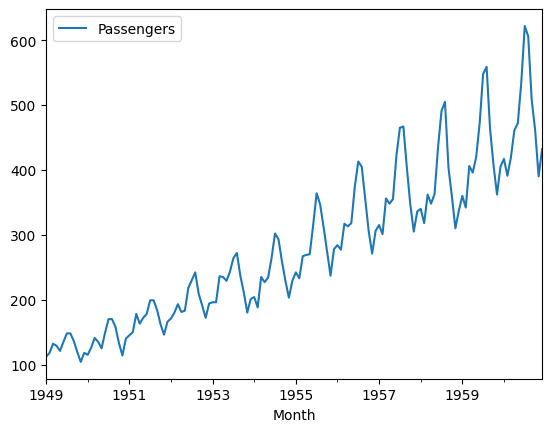

In [4]:
df.plot()

In [5]:
alpha = 0.2

In [6]:
df['EWM'] = df['Passengers'].ewm(alpha = alpha , adjust = False).mean()

<Axes: xlabel='Month'>

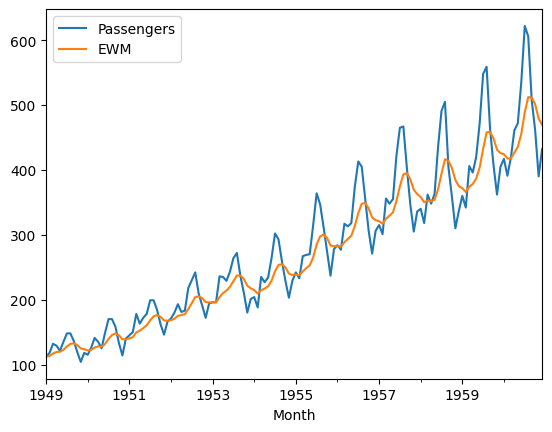

In [7]:
df.plot()

In [8]:
!pip install -U statsmodels

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.1/10.1 MB 42.6 MB/s eta 0:00:00
  Attempting uninstall: statsmodels
    Found existing installation: statsmodels 0.13.5
    Uninstalling statsmodels-0.13.5:
      Successfully uninstalled statsmodels-0.13.5


In [9]:
from statsmodels.tsa.holtwinters import SimpleExpSmoothing

In [10]:
ses = SimpleExpSmoothing(df['Passengers'])

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


In [11]:
df.index

DatetimeIndex(['1949-01-01', '1949-02-01', '1949-03-01', '1949-04-01',
               '1949-05-01', '1949-06-01', '1949-07-01', '1949-08-01',
               '1949-09-01', '1949-10-01',
               ...
               '1960-03-01', '1960-04-01', '1960-05-01', '1960-06-01',
               '1960-07-01', '1960-08-01', '1960-09-01', '1960-10-01',
               '1960-11-01', '1960-12-01'],
              dtype='datetime64[ns]', name='Month', length=144, freq=None)

In [12]:
## we set the frequency inside the index for the model creation
df.index.freq = 'MS'

In [13]:
ses = SimpleExpSmoothing(df['Passengers'],
                         initialization_method = 'legacy-heuristic')

In [14]:
### use alpha and not change it
res = ses.fit(smoothing_level = alpha , optimized = False)

In [15]:
res

In [16]:
res.predict(start = df.index[0] , end = df.index[-1])

Month
1949-01-01    112.000000
1949-02-01    112.000000
1949-03-01    113.200000
1949-04-01    116.960000
1949-05-01    119.368000
                 ...    
1960-08-01    488.767616
1960-09-01    512.214093
1960-10-01    511.371274
1960-11-01    501.297019
1960-12-01    479.037615
Freq: MS, Length: 144, dtype: float64

In [17]:
df['SES'] = res.predict(start = df.index[0] , end = df.index[-1])

<Axes: xlabel='Month'>

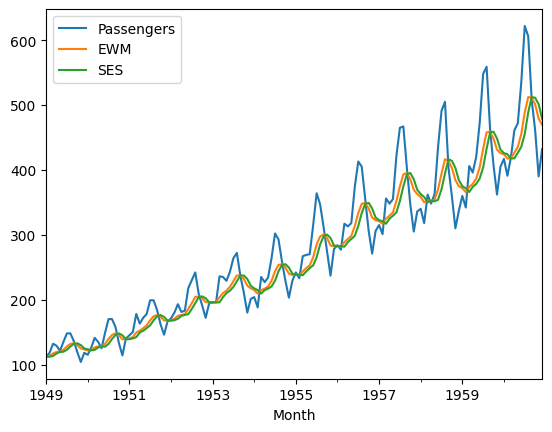

In [18]:
df.plot()

In [19]:
##### Let's do some forecasting
N_test = 12
train = df.iloc[:-N_test]
test = df.iloc[-N_test:]

In [20]:
ses = SimpleExpSmoothing(train['Passengers'],
                         initialization_method = 'legacy-heuristic')
res = ses.fit()

In [21]:
#### boolean series to index df rows
train_idx = df.index <= train.index[-1]
test_idx = df.index > train.index[-1]

<Axes: xlabel='Month'>

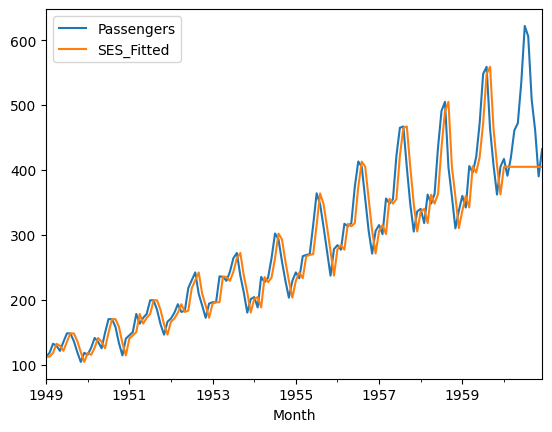

In [22]:
df.loc[train_idx , 'SES_Fitted'] = res.fittedvalues
df.loc[test_idx , 'SES_Fitted'] = res.forecast(N_test)
df[['Passengers' , 'SES_Fitted']].plot()

In [23]:
res.params

{'smoothing_level': 0.995,
 'smoothing_trend': nan,
 'smoothing_seasonal': nan,
 'damping_trend': nan,
 'initial_level': 112.0,
 'initial_trend': nan,
 'initial_seasons': array([], dtype=float64),
 'use_boxcox': False,
 'lamda': None,
 'remove_bias': False}

In [24]:
############# Holt-Winters ######################3
from statsmodels.tsa.holtwinters import Holt

In [25]:
holt = Holt(df['Passengers'],
            initialization_method = 'legacy-heuristic')

In [26]:
res_h = holt.fit()

In [27]:
df['Holt'] = res_h.fittedvalues

<Axes: xlabel='Month'>

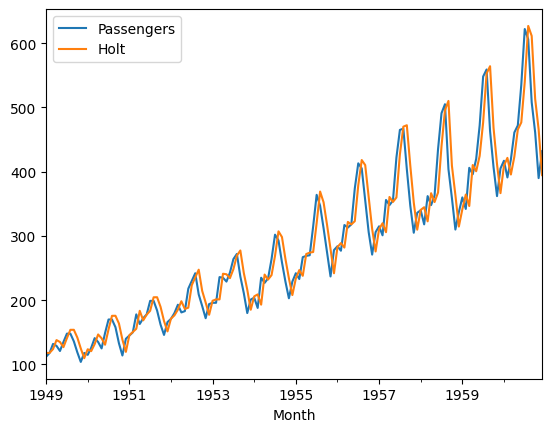

In [28]:
df[['Passengers' , 'Holt']].plot()

In [29]:
holt = Holt(train['Passengers'],
            initialization_method = 'legacy-heuristic')
res_h = holt.fit()
df.loc[train_idx , 'Holt'] = res_h.fittedvalues
df.loc[test_idx , 'Holt'] = res_h.forecast(N_test)

<Axes: xlabel='Month'>

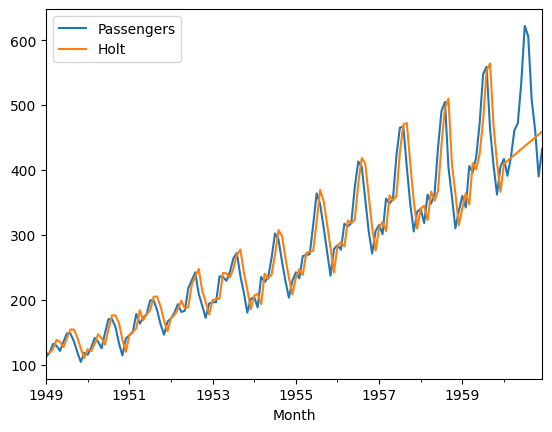

In [30]:
df[['Passengers' , 'Holt']].plot()

In [31]:
from statsmodels.tsa.holtwinters import ExponentialSmoothing

In [33]:
hw = ExponentialSmoothing(train['Passengers'],
                          initialization_method = 'legacy-heuristic',
                          trend='add',
                          seasonal = 'add',
                          seasonal_periods= 12)
res_hw = hw.fit()

In [34]:
df.loc[train_idx , 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx , 'HoltWinters'] = res_hw.forecast(N_test)


<Axes: xlabel='Month'>

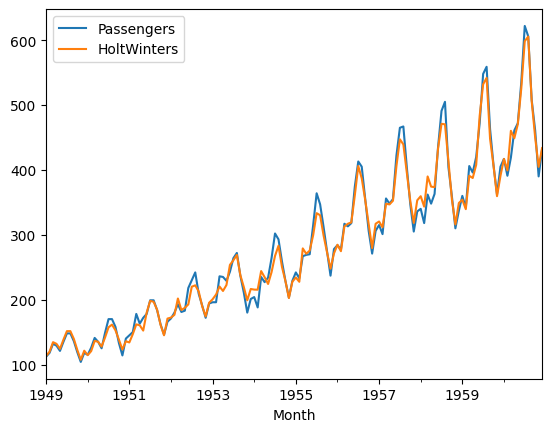

In [35]:
df[['Passengers', 'HoltWinters']].plot()

In [36]:
def rmse(y , t):
  return np.sqrt(np.mean((y-t)**2))

In [37]:
def mae(y , t):
  return np.mean(np.abs(y-t))

In [39]:
print("Train rmse: ",  rmse(train['Passengers'], res_hw.fittedvalues) )
print("Test rmse: ",  rmse(test['Passengers'], res_hw.forecast(N_test)) )

Train rmse:  11.853000976828765
Test rmse:  15.543003084126884


In [40]:
print("Train mae: ",  mae(train['Passengers'], res_hw.fittedvalues) )
print("Test mae: ",  mae(test['Passengers'], res_hw.forecast(N_test)) )

Train mae:  8.892127530485896
Test mae:  10.43776563928059


<Axes: xlabel='Month'>

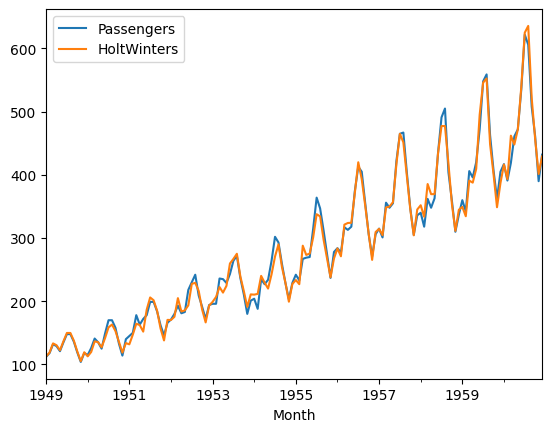

In [43]:
hw = ExponentialSmoothing(train['Passengers'],
                          initialization_method = 'legacy-heuristic',
                          trend='add',
                          seasonal = 'mul',
                          seasonal_periods= 12)
res_hw = hw.fit()
df.loc[train_idx , 'HoltWinters'] = res_hw.fittedvalues
df.loc[test_idx , 'HoltWinters'] = res_hw.forecast(N_test)
df[['Passengers', 'HoltWinters']].plot()

In [42]:
print("Train rmse: ",  rmse(train['Passengers'], res_hw.fittedvalues) )
print("Test rmse: ",  rmse(test['Passengers'], res_hw.forecast(N_test)) )

Train rmse:  10.153934838980392
Test rmse:  16.535212108255575
